Training data shape: X_train = (8760, 24, 9), y_train = (8760,)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step 
Epoch 0/300, D Loss Real: 0.6862425804138184, D Loss Fake: 0.6923152208328247, G Loss: 0.365342378616333
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 20/300, D Loss Real: 0.706

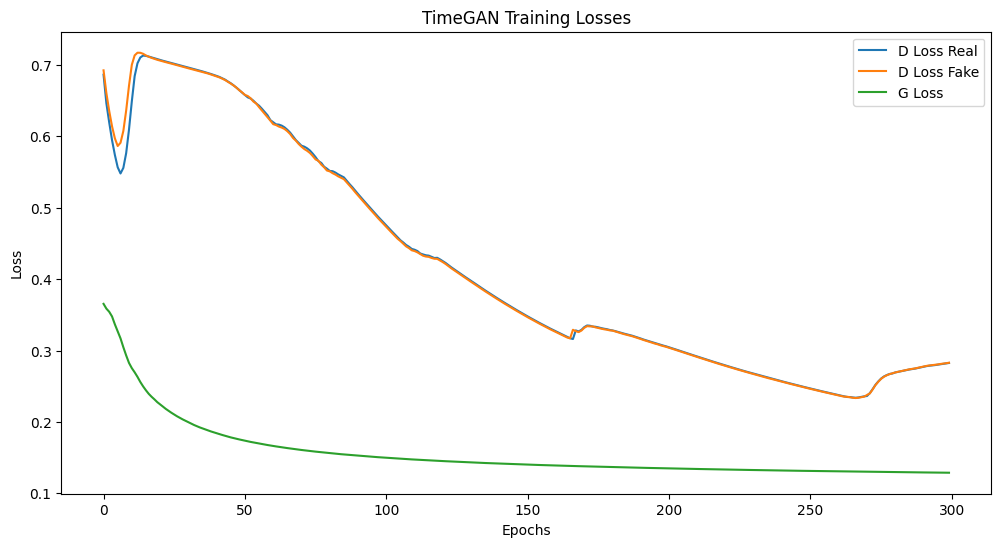

274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Generation 1: MAE: 17731.7195, MSE: 415555711.2264


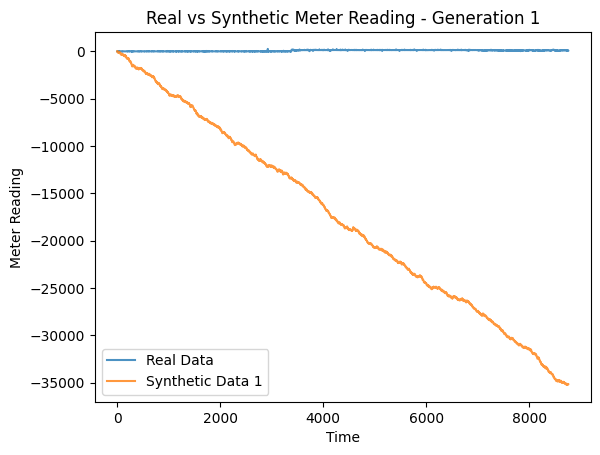

Generation 2: MAE: 22539.8851, MSE: 661413561.8377


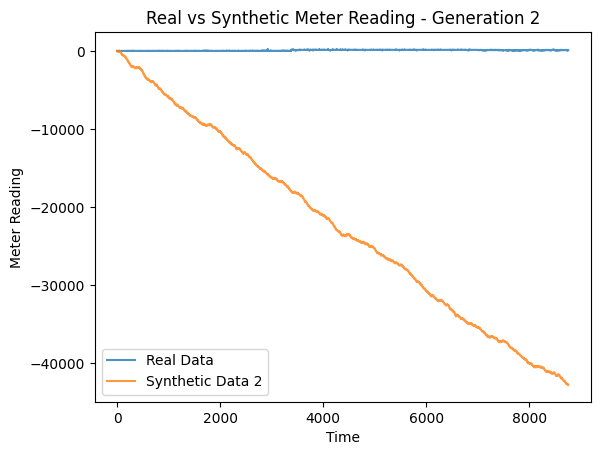

Generation 3: MAE: 21795.5794, MSE: 620606636.4561


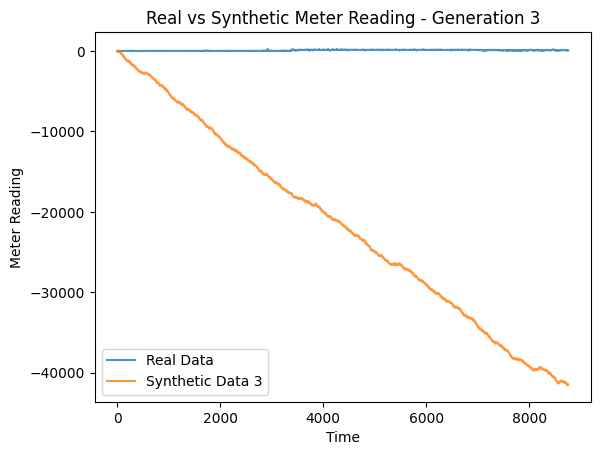

Generation 4: MAE: 18090.0016, MSE: 442364711.8150


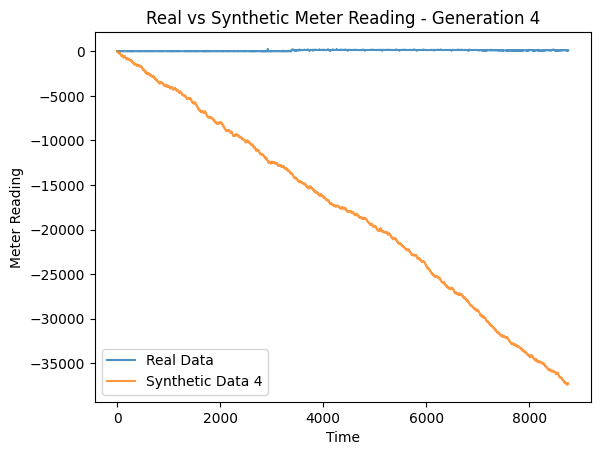

Generation 5: MAE: 19481.8753, MSE: 519435448.4208


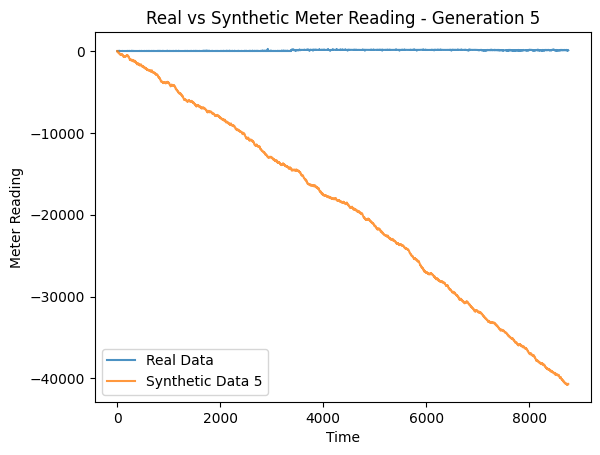

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load data
data = pd.read_csv('train.csv', parse_dates=['timestamp'])

# Filter data for building_id = 1 and meter = 0
data = data[(data['building_id'] == 1) & (data['meter'] == 0)].reset_index(drop=True)

# Sort data by timestamp
data = data.sort_values(by='timestamp').reset_index(drop=True)

# Extract cyclical time features
def create_time_features(df):
    df['hour'] = df['timestamp'].dt.hour
    df['day'] = df['timestamp'].dt.day
    df['month'] = df['timestamp'].dt.month
    df['weekday'] = df['timestamp'].dt.weekday

    # Create cyclical features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)
    return df

# Apply feature engineering
data = create_time_features(data)

# Apply differencing to make the series stationary
def apply_differencing(df, col):
    df['diff_meter_reading'] = df[col].diff().fillna(0)
    return df

data = apply_differencing(data, 'meter_reading')

# Normalize data
scaler = MinMaxScaler()
feature_cols = ['diff_meter_reading', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
                'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos']

data[feature_cols] = scaler.fit_transform(data[feature_cols])

# Prepare training sequences
sequence_length = 24  # Using 24-hour sequences for training

def create_sequences(df, seq_len):
    X, y = [], []
    for i in range(len(df) - seq_len):
        seq = df.iloc[i:i + seq_len][feature_cols].values
        X.append(seq)
        y.append(df.iloc[i + seq_len]['diff_meter_reading'])
    return np.array(X), np.array(y)

# Generate training sequences
X_train, y_train = create_sequences(data, sequence_length)

print(f"Training data shape: X_train = {X_train.shape}, y_train = {y_train.shape}")

# Define TimeGAN components
def build_generator(latent_dim, seq_len, feature_dim):
    inputs = Input(shape=(seq_len, latent_dim))
    x = LSTM(128, return_sequences=True)(inputs)
    x = LSTM(128, return_sequences=True)(x)
    outputs = Dense(feature_dim)(x)
    return Model(inputs, outputs, name='Generator')

def build_discriminator(seq_len, feature_dim):
    inputs = Input(shape=(seq_len, feature_dim))
    x = LSTM(128, return_sequences=False)(inputs)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs, name='Discriminator')

def build_embedder(seq_len, feature_dim):
    inputs = Input(shape=(seq_len, feature_dim))
    x = LSTM(128, return_sequences=True)(inputs)
    x = LSTM(128, return_sequences=False)(x)
    outputs = Dense(128, activation='relu')(x)
    return Model(inputs, outputs, name='Embedder')

# Set dimensions
latent_dim = 10
feature_dim = X_train.shape[2]

# Build models
generator = build_generator(latent_dim, sequence_length, feature_dim)
discriminator = build_discriminator(sequence_length, feature_dim)
embedder = build_embedder(sequence_length, feature_dim)

# Compile models
generator.compile(optimizer='adam', loss='mse')
discriminator.compile(optimizer='adam', loss='binary_crossentropy')
embedder.compile(optimizer='adam', loss='mse')

# Track losses for visualization
d_losses_real, d_losses_fake, g_losses = [], [], []

# Train TimeGAN with hyperparameter tuning
epochs = 300  # Increased epochs for better convergence
batch_size = 64  # Increased batch size for smoother training

for epoch in range(epochs):
    # Sample noise and generate synthetic data
    noise = np.random.normal(0, 1, (batch_size, sequence_length, latent_dim))
    generated_data = generator.predict(noise)

    # Get real data
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_data = X_train[idx]

    # Train discriminator
    d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(generated_data, np.zeros((batch_size, 1)))

    # Train generator
    noise = np.random.normal(0, 1, (batch_size, sequence_length, latent_dim))
    g_loss = generator.train_on_batch(noise, real_data)

    # Save losses for visualization
    d_losses_real.append(d_loss_real)
    d_losses_fake.append(d_loss_fake)
    g_losses.append(g_loss)

    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{epochs}, D Loss Real: {d_loss_real}, D Loss Fake: {d_loss_fake}, G Loss: {g_loss}")

# Plot loss curves
plt.figure(figsize=(12, 6))
plt.plot(d_losses_real, label='D Loss Real')
plt.plot(d_losses_fake, label='D Loss Fake')
plt.plot(g_losses, label='G Loss')
plt.title('TimeGAN Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate synthetic data
def generate_synthetic_data(generator, seq_len, latent_dim, scaler, feature_dim, n_samples):
    noise = np.random.normal(0, 1, (n_samples, seq_len, latent_dim))
    synthetic_data = generator.predict(noise)

    # Reshape and inverse transform
    synthetic_data_reshaped = synthetic_data.reshape(-1, feature_dim)
    synthetic_data_reshaped = scaler.inverse_transform(synthetic_data_reshaped)
    synthetic_data_reshaped = synthetic_data_reshaped[:, 0]  # Extract diff_meter_reading
    return synthetic_data_reshaped[:len(data) - seq_len]  # Match original length

# Generate multiple synthetic samples for verification
n_samples = len(data) - sequence_length
synthetic_samples = []
n_generations = 5  # Generate 5 synthetic datasets for validation

for _ in range(n_generations):
    synthetic_samples.append(generate_synthetic_data(generator, sequence_length, latent_dim, scaler, feature_dim, n_samples))

# Apply inverse differencing with proper length
def apply_inverse_differencing(original_series, diff_series):
    restored_series = [original_series[0]]  # Start with initial value
    for diff in diff_series:
        restored_series.append(restored_series[-1] + diff)
    return np.array(restored_series[:len(original_series)])  # Ensure proper length

# Restore synthetic meter_reading values for each generation
original_series = data['meter_reading'].values[:len(synthetic_samples[0])]
synthetic_meter_readings = [apply_inverse_differencing(original_series, sample) for sample in synthetic_samples]

# Evaluate performance for each synthetic dataset
def evaluate_performance(real_series, synthetic_series_list):
    real_series_trimmed = real_series[:len(synthetic_series_list[0])]
    
    for i, synthetic_series in enumerate(synthetic_series_list):
        synthetic_series_trimmed = synthetic_series[:len(real_series_trimmed)]
        
        mae = mean_absolute_error(real_series_trimmed, synthetic_series_trimmed)
        mse = mean_squared_error(real_series_trimmed, synthetic_series_trimmed)
        
        print(f"Generation {i + 1}: MAE: {mae:.4f}, MSE: {mse:.4f}")
        
        plt.plot(real_series_trimmed, label='Real Data', alpha=0.8)
        plt.plot(synthetic_series_trimmed, label=f'Synthetic Data {i + 1}', alpha=0.8)
        plt.title(f'Real vs Synthetic Meter Reading - Generation {i + 1}')
        plt.xlabel('Time')
        plt.ylabel('Meter Reading')
        plt.legend()
        plt.show()

# Evaluate and visualize results
evaluate_performance(original_series, synthetic_meter_readings)